# Template for Analysis


### Imports and setup

In [2]:
import os, sys
pth = os.getcwd()
pth = pth.split('/jupyter')[0] + '/app'
sys.path.insert(0, pth)

import scraper, parser, config, db, models
import chess, chess.pgn
import numpy as np
from sqlalchemy import func
from sqlalchemy.sql import text
import pandas as pd

### configure environment variables


In [ ]:
#Account configuration, this is mandatory
os.environ['ACCOUNT_NAME'] = 'myaccount'
os.environ['ACCOUNT_PASSWORD'] = 'mypassword'

#DB Configuration
os.environ["POSTGRES_USER"] = 'postgres'
os.environ["POSTGRES_PASSWORD"] = 'password'
os.environ["POSTGRES_DB"] = 'postgres'
os.environ["POSTGRES_HOST"] = 'localhost'
os.environ["POSTGRES_PORT"] = '5432'

#os.environ["DOWNLOAD_PATH"]
os.environ["START_DATE"] = '07/01/2023'
os.environ["END_DATE"] = '07/28/2023'


### Parse environment variables and initialize database connection

In [3]:
conf = config.Config()
session = db.get_session(conf)

# Interacting with the Database

## Example: Database Tables

In [17]:
game = session.query(models.GameRecord).first()
game_columns = models.GameRecord.__table__.columns.keys()
for col in game_columns:
    print(f'{col}: {getattr(game, col, None)}')

id: 1
my_elo: 888
opp_elo: 1044
result: W
ending: resignation
white: False
op_name: YourWaaayTooSlowBrah
date_played: 2020-09-11 21:55:47
timecontrol: 120+1


In [15]:
move = game.moves[0]
move_columns = models.Move.__table__.columns.keys()
for col in move_columns:
    print(f'{col}: {getattr(move, col, None)}')

id: 1
game_id: 1
movenumber: 1
move: e4


In [18]:
dl = session.query(models.Download).first()
dl_columns = models.Download.__table__.columns.keys()
for col in dl_columns:
    print(f'{col}: {getattr(dl, col, None)}')

id: 1
filename: 216.pgn


## Example: Querying and Pandas
### Time Control Groups

Ratings are grouped into 'bullet', 'blitz', and 'rapid', with multiple different time controls falling in each group. Following queries find results for each group

In [80]:
bullet = session.query(models.GameRecord).where(models.GameRecord.timecontrol.in_(['60', '60+1', '120+1']))
blitz = session.query(models.GameRecord).where(models.GameRecord.timecontrol.in_(['180', '180+2', '300']))
rapid = session.query(models.GameRecord).where(models.GameRecord.timecontrol.in_(['600', '900+10', '1800']))
allforms = session.query(models.GameRecord)

In [81]:
df_rapid = pd.read_sql(rapid.statement, session.bind)
df_blitz = pd.read_sql(blitz.statement, session.bind)
df_bullet = pd.read_sql(bullet.statement, session.bind)
df_all = pd.read_sql(allforms.statement, session.bind)
df_rapid.head(5)

,id,my_elo,opp_elo,result,ending,white,op_name,date_played,timecontrol
0,292,1479,1247,W,time,True,slawekkoenig,2021-03-03 13:48:19,600
1,293,1471,1500,L,resignation,False,bazrsad08,2021-03-03 13:57:33,600
2,294,1474,1224,W,resignation,False,Jenda95,2021-03-03 14:00:11,600
3,295,1466,1481,L,time,False,HalilSaracHS,2021-03-03 14:18:17,600
4,296,1469,1238,W,resignation,False,Slobodan1981,2021-03-03 14:20:12,600


Reindex by date_played

In [82]:
df_rapid = df_rapid.sort_values(by='date_played')
df_rapid = df_rapid.set_axis(range(len(df_rapid)))
df_rapid.head(5)

,id,my_elo,opp_elo,result,ending,white,op_name,date_played,timecontrol
0,5851,1162,838,W,checkmate,True,yiyi14,2020-05-20 19:52:38,600
1,5852,1011,1149,L,resignation,False,jerst458,2020-05-20 20:09:43,600
2,5853,928,1176,L,resignation,False,SmoggyMink,2020-05-20 20:22:23,600
3,5854,1008,837,W,time,True,HK465,2020-05-20 20:40:54,600
4,5855,1003,984,None,draw,True,HITHOR,2020-05-20 20:54:31,600


In [83]:
g = df_all.groupby('timecontrol')
for timecontrol, groupdf in g:
    print(f'Time control: {timecontrol}, Peak elo: {groupdf.loc[:,"my_elo"].max()}')

Time control: 120+1, Peak elo: 1129
Time control: 180+2, Peak elo: 1301
Time control: 300, Peak elo: 1001
Time control: 60, Peak elo: 1029
Time control: 60+1, Peak elo: 1123
Time control: 600, Peak elo: 1722
Time control: 900+10, Peak elo: 1290


# Plotting
The discontinuities in the elo vs time and elo vs game played graphs make more sense when presented side by side. 
The large jumps in elo coincide with returns from long absences from playing rapid, during which I was getting bettr in other formats.

<Axes: >

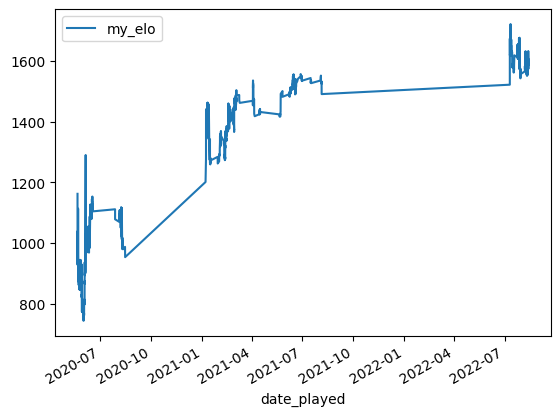

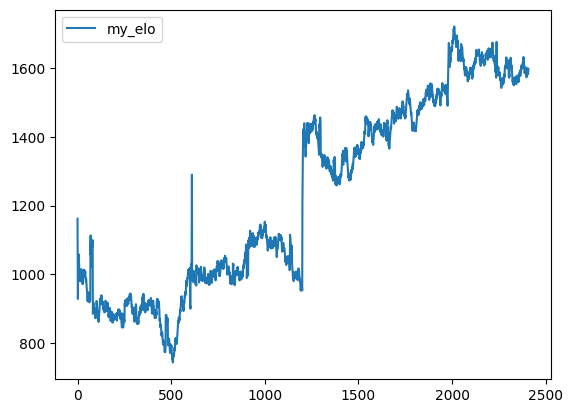

In [89]:
df_rapid = pd.read_sql(rapid.statement, session.bind)
df_rapid.plot(x='date_played', y='my_elo')
df_rapid = df_rapid.sort_values(by='date_played')
df_rapid = df_rapid.set_axis(range(len(df_rapid)))
df_rapid.plot(y='my_elo')